In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Here we simply predict the next step in the sequence. Each model is trained on 1/4 of the data

In [2]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [3]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [4]:
def MSE(prediction_tensor, truth_tensor):
    return torch.sum(torch.pow(prediction_tensor-truth_tensor, 2))/truth_tensor.numel()

In [5]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [6]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [7]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [8]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [9]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='mps')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='mps') # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='mps')  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='mps')  # (batch, output_dim)


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[-1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("mps")  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

# criterion2 = nn.SmoothL1Loss()
# optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
# criterion3 = nn.SmoothL1Loss()
# optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [11]:
train_seq_tensor1.shape

torch.Size([142, 12, 1])

In [12]:
val_seq_tensor1.shape

torch.Size([27, 12, 1])

In [13]:
first_piece.shape

(193, 1)

In [14]:
len(train_seq_tensor1)

142

In [15]:
train_seq_tensor1[0].shape

torch.Size([12, 1])

In [17]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model1.train()
    
        optimizer1.zero_grad()
        y_pred = model1(train_seq_tensor1[i])
        loss = criterion1(y_pred, train_label_tensor1[i])
        print(loss.item())
        loss.backward()
        optimizer1.step()
    
        train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


0.0829717218875885
0.0645175576210022
0.04171154275536537
0.04486367106437683
0.014057326130568981
0.0034432464744895697
0.00017962527635972947
9.009292261907831e-05
0.012493106536567211
0.014235098846256733
0.013893005438148975
0.01830204762518406
0.03552787005901337
0.027817634865641594
0.0400802418589592
0.073294498026371
0.1108158603310585
0.1055145263671875
0.15694428980350494
0.1503174751996994
0.17923831939697266
0.2551547586917877
0.1819578856229782
0.2603208124637604
0.2546306252479553
0.2969275414943695
0.28228408098220825
0.2504599094390869
0.11977053433656693
0.09969355165958405
0.040288958698511124
0.01357920840382576
0.014355259947478771
0.0013265275629237294
0.021956486627459526
0.0631042867898941
0.04622291028499603
0.08816422522068024
0.0757601410150528
0.04386366531252861
0.11227203160524368
0.13394364714622498
0.06327013671398163
0.07790679484605789
0.06857851147651672
0.04093912988901138
0.01992986910045147
0.008434714749455452
0.009833375923335552
0.053812336176633

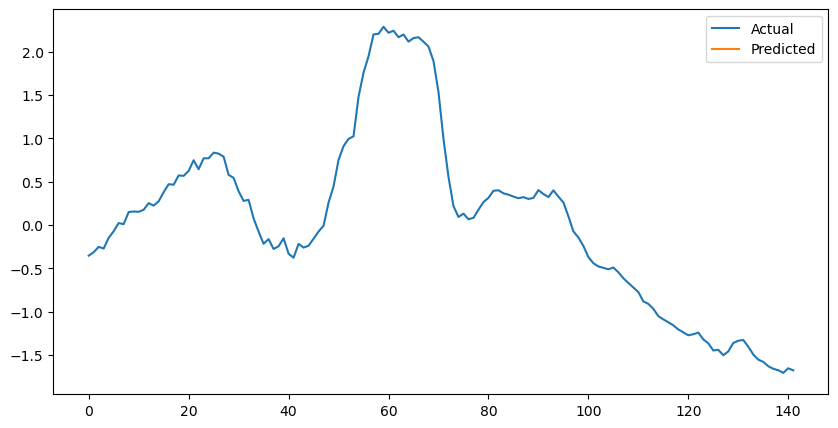

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1.cpu().numpy(), label="Actual")
plt.plot(y_pred.cpu().detach().numpy(),label="Predicted")
plt.legend()
plt.show()

## Now let's test on datasets 2, 3, 4

### First create test set 2

In [19]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 12)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device='mps')
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device='mps')

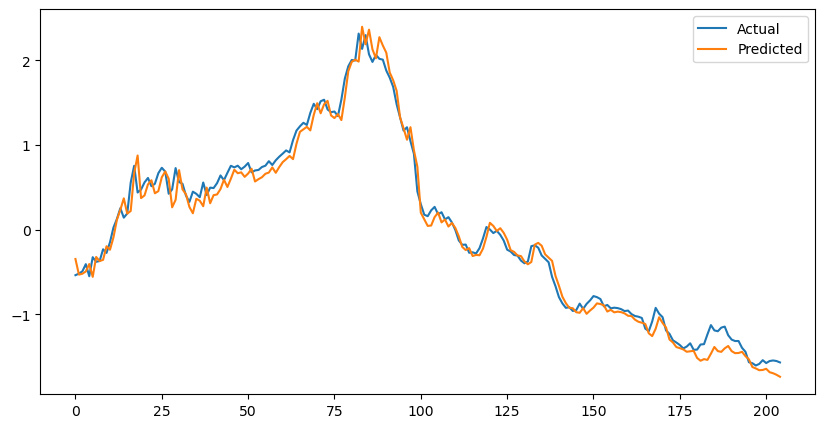

In [20]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model1(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [24]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device='mps'), test_tensor_labels_2)}')
# print(f'MSE: {MSE(y_pred, test_tensor_labels_2)}')
criterion1(torch.FloatTensor(y_pred).to(device='mps'), test_tensor_labels_2)

MARE: 1114.71630859375


/Users/ramanzatsarenko/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([205, 1])) that is different to the input size (torch.Size([205])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


tensor(0.7744, device='mps:0')

### Now dataset 3

In [285]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 12)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

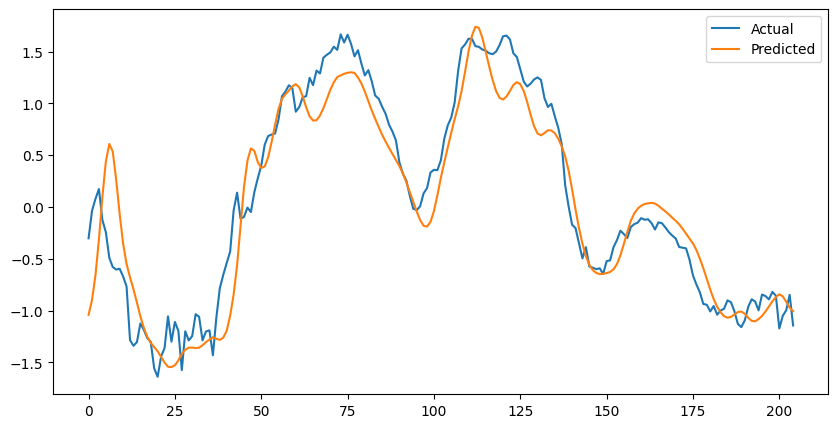

In [286]:
model1.eval()
with torch.no_grad():
    y_pred = model1(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [1]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_3)}')
criterion1(y_pred, test_tensor_labels_3)

NameError: name 'MARE' is not defined

### Finally Dataset 4

In [288]:
normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 12)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

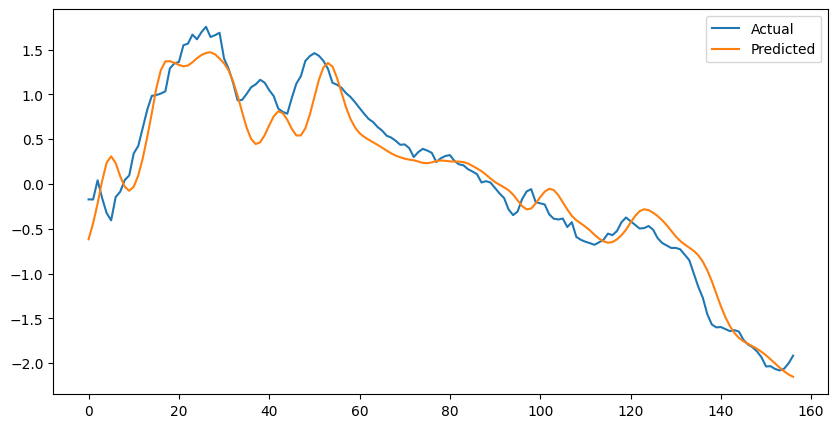

In [289]:
model1.eval()
with torch.no_grad():
    y_pred = model1(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [290]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_4)}')
criterion1(y_pred, test_tensor_labels_4)

MARE: 0.5193931460380554


## Now we train Model 2 on Dataset 2

In [291]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

In [292]:
second_piece.shape

(217, 1)

In [293]:
train_seq_tensor2.shape

torch.Size([161, 12, 1])

In [294]:
val_seq_tensor2.shape

torch.Size([32, 12, 1])

In [295]:
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cuda")  # Use "cuda" if you have a GPU
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)

In [296]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion2(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.44959330558776855, Val Loss: 1.5932105779647827
Epoch 10, Train Loss: 0.4379260241985321, Val Loss: 1.526850938796997
Epoch 20, Train Loss: 0.413576602935791, Val Loss: 1.4198296070098877
Epoch 30, Train Loss: 0.34039705991744995, Val Loss: 1.1252962350845337
Epoch 40, Train Loss: 0.14330965280532837, Val Loss: 0.20359279215335846
Epoch 50, Train Loss: 0.12506113946437836, Val Loss: 0.024758100509643555
Epoch 60, Train Loss: 0.10349515825510025, Val Loss: 0.05378192663192749
Epoch 70, Train Loss: 0.09579477459192276, Val Loss: 0.03697897493839264
Epoch 80, Train Loss: 0.09378881007432938, Val Loss: 0.0317126139998436
Epoch 90, Train Loss: 0.09043383598327637, Val Loss: 0.05370007082819939
Epoch 100, Train Loss: 0.08720901608467102, Val Loss: 0.03513851761817932
Epoch 110, Train Loss: 0.08404766023159027, Val Loss: 0.036436401307582855
Epoch 120, Train Loss: 0.0805942565202713, Val Loss: 0.036570802330970764
Epoch 130, Train Loss: 0.07669755816459656, Val Loss: 0.

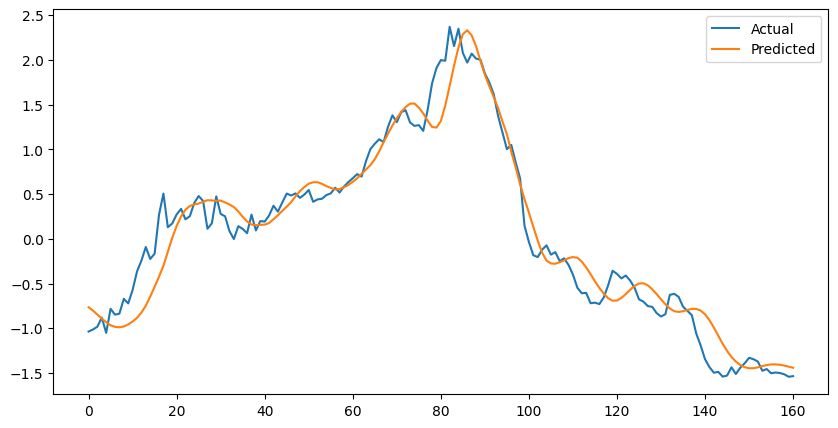

In [297]:
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor2.cpu().numpy(), label="Actual")
plt.plot(y_pred.cpu().detach().numpy(),label="Predicted")
plt.legend()
plt.show()

In [ ]:
# print(f'MSE: {MSE(y_pred, test_tensor_labels_1)}')
# criterion2(y_pred, test_tensor_labels_1)

### Test on dataset 1

In [298]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 12)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device='cuda')
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device='cuda')

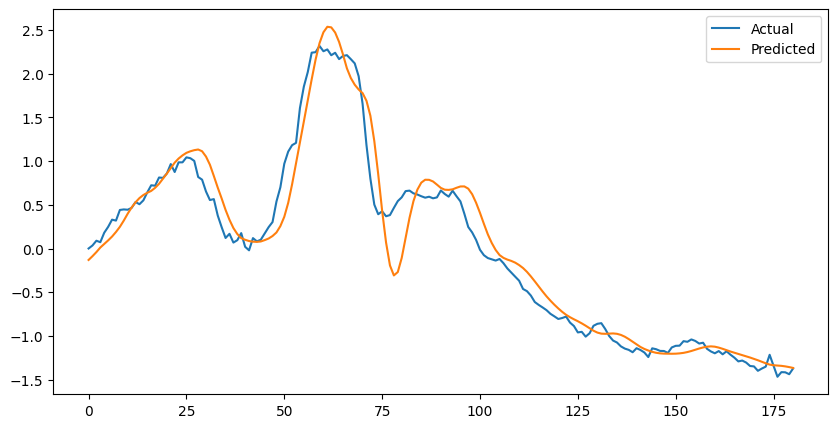

In [299]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_1)

plt.figure(figsize=(10,5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [300]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_1)}')
criterion2(y_pred, test_tensor_labels_1)

MARE: 1.8412922620773315


In [301]:
criterion2(y_pred, test_tensor_labels_1)

tensor(0.0271, device='cuda:0')

### Dataset 3

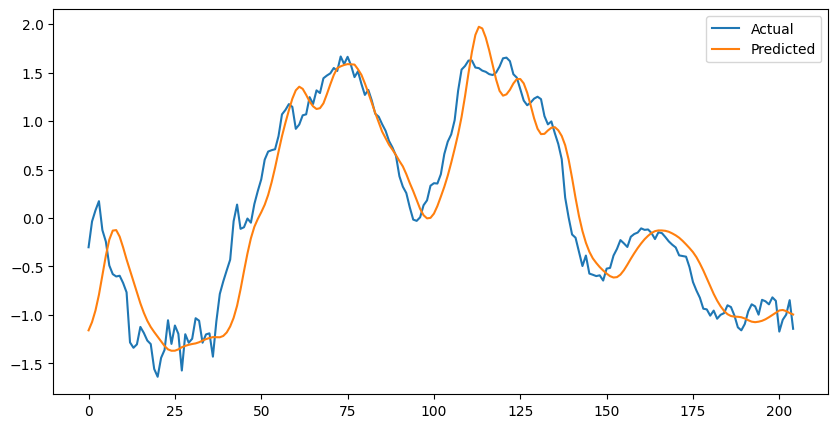

In [302]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [303]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_3)}')
criterion2(y_pred, test_tensor_labels_3)

MARE: 1.913475513458252


### Dataset 4

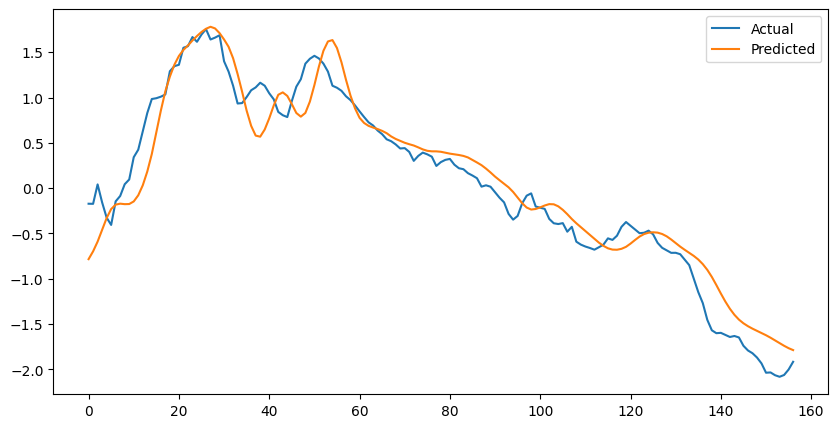

In [304]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [305]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_4)}')
criterion2(y_pred, test_tensor_labels_4)

MARE: 0.7310705780982971


### Now train Model 3 on dataset 3

In [306]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [307]:
third_piece.shape

(217, 1)

In [308]:
train_seq_tensor3.shape

torch.Size([161, 12, 1])

In [309]:
val_seq_tensor3.shape

torch.Size([32, 12, 1])

In [310]:
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to(device='cuda')
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-4)
criterion3 = nn.SmoothL1Loss()

In [311]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model3.train()

    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)

    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.44625964760780334, Val Loss: 0.5220726728439331
Epoch 10, Train Loss: 0.4276014268398285, Val Loss: 0.5865719318389893
Epoch 20, Train Loss: 0.4020906090736389, Val Loss: 0.6501835584640503
Epoch 30, Train Loss: 0.34556347131729126, Val Loss: 0.6993207931518555
Epoch 40, Train Loss: 0.24461038410663605, Val Loss: 0.517490029335022
Epoch 50, Train Loss: 0.15300580859184265, Val Loss: 0.13909395039081573
Epoch 60, Train Loss: 0.14685863256454468, Val Loss: 0.02873985469341278
Epoch 70, Train Loss: 0.12645123898983002, Val Loss: 0.08978317677974701
Epoch 80, Train Loss: 0.11671232432126999, Val Loss: 0.0825193002820015
Epoch 90, Train Loss: 0.10786895453929901, Val Loss: 0.05678344517946243
Epoch 100, Train Loss: 0.09847002476453781, Val Loss: 0.06898680329322815
Epoch 110, Train Loss: 0.08780938386917114, Val Loss: 0.05321492999792099
Epoch 120, Train Loss: 0.07504139840602875, Val Loss: 0.04960918799042702
Epoch 130, Train Loss: 0.05897466465830803, Val Loss: 0.04

### Test on dataset 1

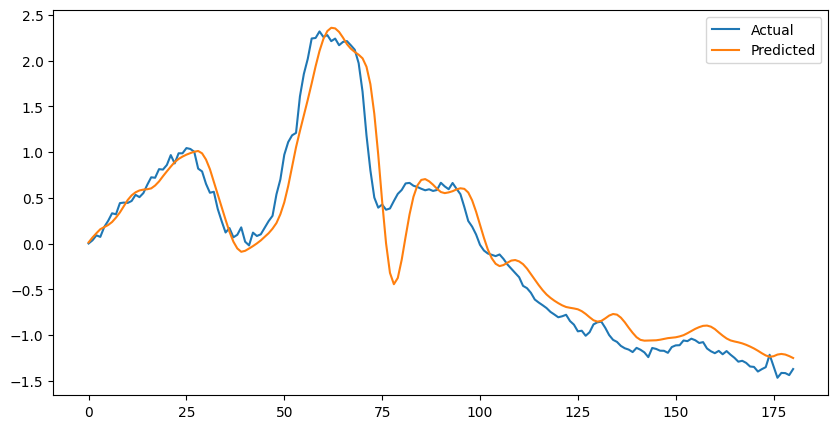

In [312]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_1)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [313]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_1)}')
criterion3(y_pred, test_tensor_labels_1)

MARE: 0.570930540561676


### Test on dataset 2

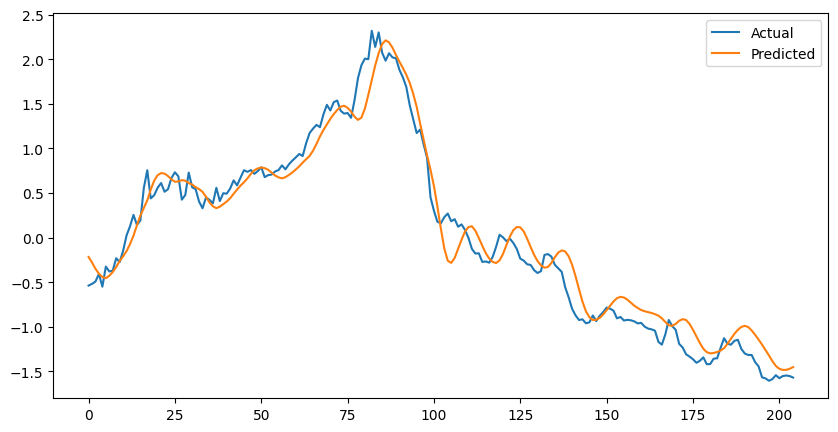

In [314]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_2)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [315]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_2)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_2)}')
criterion3(y_pred, test_tensor_labels_2)

MARE: 0.9140909910202026


### Test on dataset 4

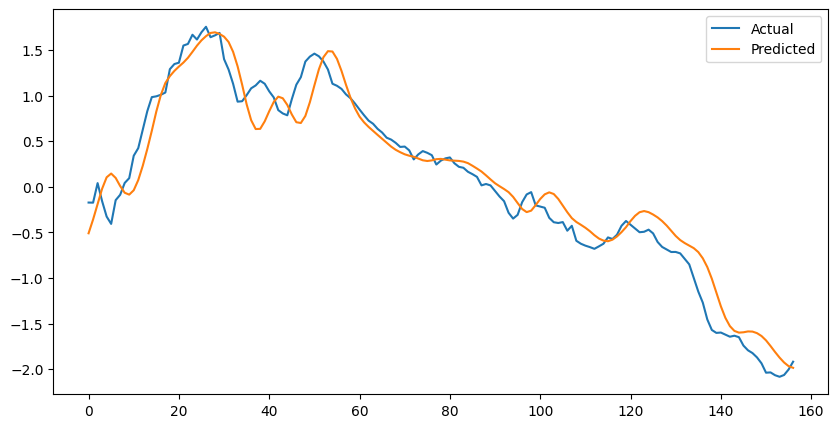

In [316]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [317]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_4)}')
criterion3(y_pred, test_tensor_labels_4)

MARE: 0.5085535049438477


## Train model 4 on dataset 4

In [318]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [319]:
fourth_piece.shape

(169, 1)

In [320]:
train_seq_tensor4.shape

torch.Size([123, 12, 1])

In [321]:
val_seq_tensor4.shape

torch.Size([22, 12, 1])

In [322]:
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion4 = nn.SmoothL1Loss()
optimizer4 = optim.Adam(model4.parameters(), lr=1e-4)
model4.to(device='cuda')

LSTMModel(
  (lstm): LSTM(1, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [323]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model4.train()
    optimizer4.zero_grad()
    y_pred = model4(train_seq_tensor4)

    loss = criterion4(y_pred, train_label_tensor4)
    train_losses.append(loss.item())
    loss.backward()
    optimizer4.step()

    # Validation
    model4.eval()
    with torch.no_grad():
        y_val = model4(val_seq_tensor4)
    val_loss = criterion4(y_val, val_label_tensor4)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.4102398455142975, Val Loss: 2.3199141025543213
Epoch 10, Train Loss: 0.3990296721458435, Val Loss: 2.327434539794922
Epoch 20, Train Loss: 0.37797415256500244, Val Loss: 2.2836103439331055
Epoch 30, Train Loss: 0.31608548760414124, Val Loss: 2.082566738128662
Epoch 40, Train Loss: 0.17023390531539917, Val Loss: 1.4798320531845093
Epoch 50, Train Loss: 0.13927465677261353, Val Loss: 0.7328543663024902
Epoch 60, Train Loss: 0.12149535119533539, Val Loss: 0.9282185435295105
Epoch 70, Train Loss: 0.11758972704410553, Val Loss: 0.8862012028694153
Epoch 80, Train Loss: 0.11137983202934265, Val Loss: 0.5786275863647461
Epoch 90, Train Loss: 0.10617213696241379, Val Loss: 0.6322110295295715
Epoch 100, Train Loss: 0.10098854452371597, Val Loss: 0.6081921458244324
Epoch 110, Train Loss: 0.09516964107751846, Val Loss: 0.5655702352523804
Epoch 120, Train Loss: 0.08865286409854889, Val Loss: 0.5690662264823914
Epoch 130, Train Loss: 0.08122152090072632, Val Loss: 0.5215814709

### Test on dataset 1

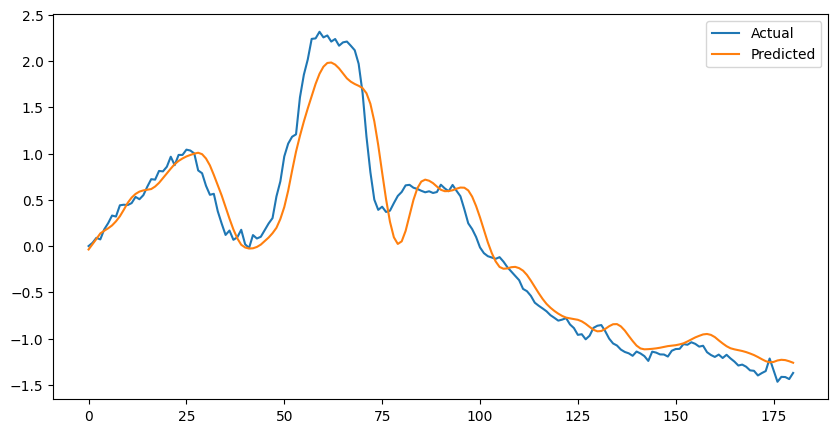

In [324]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_1)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [325]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_1)}')
criterion4(y_pred, test_tensor_labels_1)

MARE: 0.8142557144165039


### Test on dataset 2

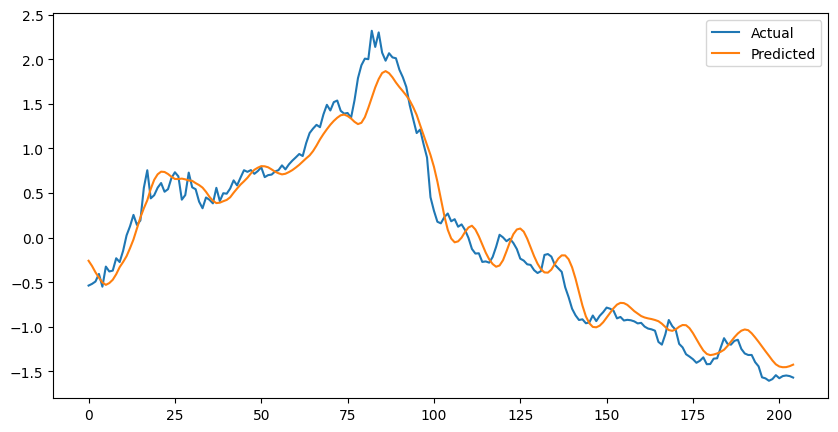

In [326]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_2)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [327]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_2)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_2)}')
criterion4(y_pred, test_tensor_labels_2)

MARE: 1.067797303199768


### Test on dataset 3

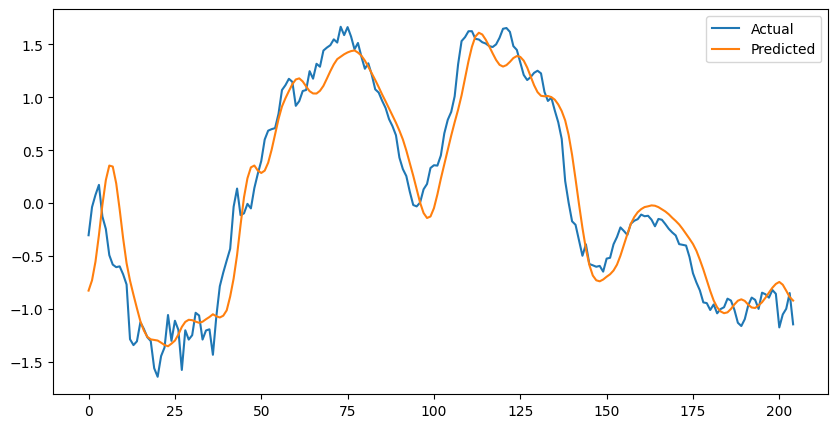

In [328]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [329]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')
print(f'MSE: {MSE(y_pred, test_tensor_labels_3)}')
criterion4(y_pred, test_tensor_labels_3)

MARE: 1.5823476314544678
